In [1]:
import pandas as pd
import math
import datetime as dt
import time
import json
import numpy as np
import warnings
import tqdm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

from xgboost import XGBClassifier

import torch
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier

import sklearn
from sklearn import svm

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel

from sklearn.impute import KNNImputer

from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [269]:
from Sleep_stress_exclude_sms_call import preprocessing

#  No call nor sms data

In [4]:
uid_list = ['u00', 'u01', 'u02', 'u03', 'u04', 'u07', 'u08', 'u09', 'u10', 'u12', #'u13',
            'u14', 'u15', 'u16', 'u17',
      'u18', 'u19', 'u20', 'u22', 'u23', 'u24', 'u25', 'u27', 'u30', 'u31', 'u32', 'u33', 'u34', 'u35', 'u36', 
      'u39', 'u41', 'u42', 'u43', 'u44', 'u45', 'u46', 'u47','u49', 'u50', 'u51', 'u52', 'u53', 'u54', 'u56', 
      'u57', 'u58' ,'u59']

dataframes = []
for uid in uid_list:
    df = preprocessing(uid)
    dataframes.append((uid, df))
    print(uid, len(df))

u00 10
u01 9
u02 7
u03 5
u04 10
u07 5
u08 25
u09 1
u10 13
u12 7
u14 10
u15 2
u16 26
u17 8
u18 4
u19 24
u20 3
u22 6
u23 15
u24 8
u25 3
u27 4
u30 9
u31 2
u32 14
u33 14
u34 2
u35 2
u36 12
u39 0
u41 1
u42 2
u43 15
u44 15
u45 5
u46 6
u47 1
u49 5
u50 0
u51 6
u52 9
u53 7
u54 3
u56 0
u57 13
u58 14
u59 35


# Predicting Stress and Sleep:

In [5]:
def transform_df(dataframe):
    ## obtain the dates as a column and re-index the dataframes
    re_index_data = []

    for tup in dataframe:
        test = tup[1]
        test = test.rename_axis('date').reset_index()
        re_index_data.append((tup[0], test))
    return re_index_data

In [6]:
transformed_data = transform_df(dataframes)

In [7]:
transformed_dataframes = [tup[1] for tup in transformed_data]

In [8]:
df3 = pd.concat(transformed_dataframes)
df3 = df3.sort_values(by='date')
max_range = len(df3)
df3 = df3.drop(['date', 'Std_stress_level', 'Median_stress_level',
               'Min_stress_level', 'Max_stress_level', 'Skew_stress_level',
               'Var_stress_level', 'Sum_stress_level'], axis=1)
df3 = df3.reset_index(drop=True)
df3

,Mean_Activity_inference,Std_Activity_inference,Median_Activity_inference,Min_Activity_inference,Max_Activity_inference,Skew_Activity_inference,Var_Activity_inference,Sum_Activity_inference,Mean_audio_inference,Std_audio_inference,...,Var_social_sleep,Mean_number_social,Std_number_social,Median_number_social,Min_number_social,Max_number_social,Skew_number_social,Var_number_social,Sum_number_social,Mean_stress_level
0,0.294428,0.695228,0,0,3,2.533992,0.483342,1955,0,0.732571,...,0.00,4.000000,0.000000,4.0,4,4,0.000000,0.000000,4,1.000000
1,0.152590,0.496856,0,0,3,3.598265,0.246866,1028,0,0.835018,...,0.00,3.000000,0.000000,3.0,3,3,0.000000,0.000000,3,2.500000
2,0.138539,0.437443,0,0,3,3.732708,0.191357,935,0,0.783262,...,0.00,3.000000,0.000000,3.0,3,3,0.000000,0.000000,6,2.166667
3,0.248774,0.692781,0,0,3,2.754788,0.479945,1674,0,0.867151,...,0.00,4.000000,0.000000,4.0,4,4,0.000000,0.000000,4,4.500000
4,0.132745,0.446104,0,0,3,4.058229,0.199009,902,0,0.732716,...,0.00,2.333333,0.471405,2.0,2,3,1.732051,0.222222,7,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,0.101164,0.440019,0,0,3,4.964656,0.193617,3121,0,0.827521,...,0.00,4.000000,0.000000,4.0,4,4,0.000000,0.000000,8,2.000000
393,0.056297,0.312272,0,0,3,6.886170,0.097514,898,0,0.769917,...,0.00,4.000000,0.000000,4.0,4,4,0.000000,0.000000,4,5.000000
394,0.191936,0.580720,0,0,3,3.451111,0.337236,7288,0,0.878100,...,20.25,5.000000,0.000000,5.0,5,5,0.000000,0.000000,5,3.500000
395,0.117769,0.455390,0,0,3,4.369397,0.207380,1871,0,0.798978,...,0.00,3.000000,0.000000,3.0,3,3,0.000000,0.000000,3,2.000000


# Correlation Analysis:

In [9]:
correlation_df = df3.corr()
correlation_df

,Mean_Activity_inference,Std_Activity_inference,Median_Activity_inference,Min_Activity_inference,Max_Activity_inference,Skew_Activity_inference,Var_Activity_inference,Sum_Activity_inference,Mean_audio_inference,Std_audio_inference,...,Var_social_sleep,Mean_number_social,Std_number_social,Median_number_social,Min_number_social,Max_number_social,Skew_number_social,Var_number_social,Sum_number_social,Mean_stress_level
Mean_Activity_inference,1.000000,0.743307,0.684218,NaN,NaN,-0.375036,0.774368,0.658959,0.413569,0.172074,...,0.079104,0.208312,0.024610,0.201798,0.204896,0.212907,0.122500,0.015749,0.264528,0.099943
Std_Activity_inference,0.743307,1.000000,0.105613,NaN,NaN,-0.569798,0.957683,0.697625,0.507639,0.346982,...,0.099565,0.349408,0.050358,0.341673,0.341151,0.357422,0.165551,0.048321,0.382441,0.048115
Median_Activity_inference,0.684218,0.105613,1.000000,NaN,NaN,-0.107691,0.089128,0.224192,-0.021425,-0.041477,...,-0.008542,-0.041824,-0.024986,-0.041794,-0.037149,-0.045218,-0.000437,-0.021442,-0.043173,0.119908
Min_Activity_inference,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Max_Activity_inference,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Max_number_social,0.212907,0.357422,-0.045218,NaN,NaN,-0.233404,0.330026,0.377374,0.255161,0.308937,...,0.137861,0.985714,0.186238,0.982739,0.943945,1.000000,0.043373,0.166634,0.606127,0.103426
Skew_number_social,0.122500,0.165551,-0.000437,NaN,NaN,-0.201200,0.182453,0.091345,0.112585,0.002406,...,-0.054470,0.013825,-0.034024,-0.046068,0.051741,0.043373,1.000000,-0.087733,0.100939,-0.002793
Var_number_social,0.015749,0.048321,-0.021442,NaN,NaN,0.005290,0.043427,-0.003239,0.039483,0.101766,...,0.071021,0.015337,0.941952,0.027827,-0.148043,0.166634,-0.087733,1.000000,0.417437,0.005619
Sum_number_social,0.264528,0.382441,-0.043173,NaN,NaN,-0.152821,0.399499,0.333406,0.257563,0.252285,...,0.102297,0.525463,0.506970,0.526084,0.435393,0.606127,0.100939,0.417437,1.000000,0.034272


In [10]:
## Investigate correlation analysis with only the label 

In [11]:
correlation_df['Mean_stress_level'].dropna().sort_values(ascending=False)[:10]

Mean_stress_level               1.000000
number of distinct locations    0.136415
Sum_audio_inference             0.132861
Median_Activity_inference       0.119908
Sum_Activity_inference          0.116450
Median_number_social            0.105463
Mean_number_social              0.104632
Max_number_social               0.103426
Min_number_social               0.100979
Mean_Activity_inference         0.099943
Name: Mean_stress_level, dtype: float64

In [12]:
#fig, axs = plt.subplots(1,1, figsize=(14,10))
#s = 100

#axs.scatter(df3['Mean_stress_level'],df3['number of distinct locations'], s=100, zorder=-5)

#for axis in ['top','bottom','left','right']:
 #   axs.spines[axis].set_linewidth(6)
    
#axs.grid(True)
#axs.set_ylabel('Number of distinct locations', fontsize=60)
#axs.xaxis.set_ticks_position('both')
#axs.set_xlabel('Mean stress level', fontsize=60)
#axs.yaxis.set_ticks_position('both')
#axs.tick_params(which='both', length=30, width=6, direction="in", pad=10)


#axs.tick_params(labelsize=35)

#plt.tight_layout()

# Feature Vector:

In [13]:
df4 = df3.drop(['Mean_stress_level'], axis=1)
X = df4.to_numpy()
## 0 -> Signs of stress
## 1 -> No signs of stress
y = np.array([0 if val>=1 and val <4 else 1 for val in df3['Mean_stress_level']])
y = y.astype('int')

In [14]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)

The shape of X is (397, 104)
The shape of y is (397,)


## Feature Normalization:

In [15]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

## Feature Selection:

In [16]:
estimator = RandomForestClassifier(n_estimators = 100)
sel = RFECV(estimator, step=1, cv=5)
sel.fit(X_norm, y)

RFECV(cv=5, estimator=RandomForestClassifier())

In [17]:
sel.get_support()

array([ True,  True, False, False, False,  True,  True,  True, False,
        True, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True, False,  True,  True, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True, False,
        True,  True,  True,  True, False,  True, False,  True, False,
        True, False,  True,  True, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [18]:
feature_name = df4.columns.to_numpy()
important_features = feature_name[sel.get_support()]
important_features

array(['Mean_Activity_inference', 'Std_Activity_inference',
       'Skew_Activity_inference', 'Var_Activity_inference',
       'Sum_Activity_inference', 'Std_audio_inference',
       'Skew_audio_inference', 'Var_audio_inference',
       'Sum_audio_inference', 'Mean_conv_duration', 'Std_conv_duration',
       'Median_conv_duration', 'Min_conv_duration', 'Max_conv_duration',
       'Skew_conv_duration', 'Var_cov_duration', 'Mean_dark_duration',
       'Std_dark_duration', 'Median_dark_duration', 'Min_dark_duration',
       'Max_dark_duration', 'Skew_dark_duration', 'Var_dark_duration',
       'Mean_latitude', 'Mean_longitude', 'Std_latitude', 'Std_longitude',
       'Std_travelstate', 'Median_latitude', 'Median_longitude',
       'Min_latitude', 'Min_longitude', 'Max_latitude', 'Max_longitude',
       'Skew_latitude', 'Skew_longitude', 'Skew_travelstate',
       'Var_latitude', 'Var_travelstate', 'Sum_travelstate',
       'Mean_phone_charge_duration', 'Std_phone_charge_duration',
       

In [19]:
X_important = X_norm[:,sel.get_support()]

In [20]:
X_important.shape

(397, 59)

## Train, Test split:

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_important,y, test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((277, 59), (120, 59), (277,), (120,))

# XGBoost: 

In [25]:
xgb_model = XGBClassifier(booster = 'gbtree', use_label_encoder=False)
xgb_tree_parameters = {'eta': [0.1, 0.01], 'max_depth':[6, 7, 8],
                       'learning_rate': [0.05, 0.005],
                      'sampling_method':['uniform', 'gradient_based'], 
                      'tree_method': ['auto'], 'max_bin': [64, 128],
                      'lambda':[1, 0.1, 0.01], 'alpha':[1, 0.1, 0.01]}

In [26]:
%%time
xgb_tree = GridSearchCV(xgb_model, xgb_tree_parameters, refit=True, n_jobs = -1, verbose=2) ## 5 cross val folds
xgb_tree.fit(X_train, y_train, eval_metric= 'logloss')
xgb_tree_best = xgb_tree.best_estimator_

print('*'*20, 'Validation', '*'*20)
print(classification_report(y_val, xgb_tree.predict(X_val)))
print('\n')
print('*'*20, 'Best estimator:', '*'*20, '\n', xgb_tree.best_estimator_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
******************** Validation ********************
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       100
           1       0.00      0.00      0.00        20

    accuracy                           0.83       120
   macro avg       0.42      0.50      0.45       120
weighted avg       0.69      0.83      0.76       120



******************** Best estimator: ******************** 
 XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              lambda=0.01, learning_rate=0.05, max_bin=64, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=

In [252]:
feat_importances_xgb_tree = pd.DataFrame(zip(important_features, 
                                             xgb_tree_best.feature_importances_), 
                                         columns = ['Features', 'Importance'])

In [253]:
ordered_feat_imp_tree = feat_importances_xgb_tree.sort_values(by=['Importance'])
ordered_feat_imp_tree = ordered_feat_imp_tree.reset_index()

In [254]:
ordered_feat_imp_tree

,index,Features,Importance
0,22,Var_dark_duration,0.000000
1,37,Var_latitude,0.000000
2,3,Var_Activity_inference,0.000000
3,38,Var_travelstate,0.000000
4,50,Var_phone_lock_duration,0.000000
5,39,Sum_travelstate,0.000000
6,7,Var_audio_inference,0.000000
7,15,Var_cov_duration,0.000000
8,57,Median_hour_sleep,0.000000
9,26,Std_longitude,0.006397


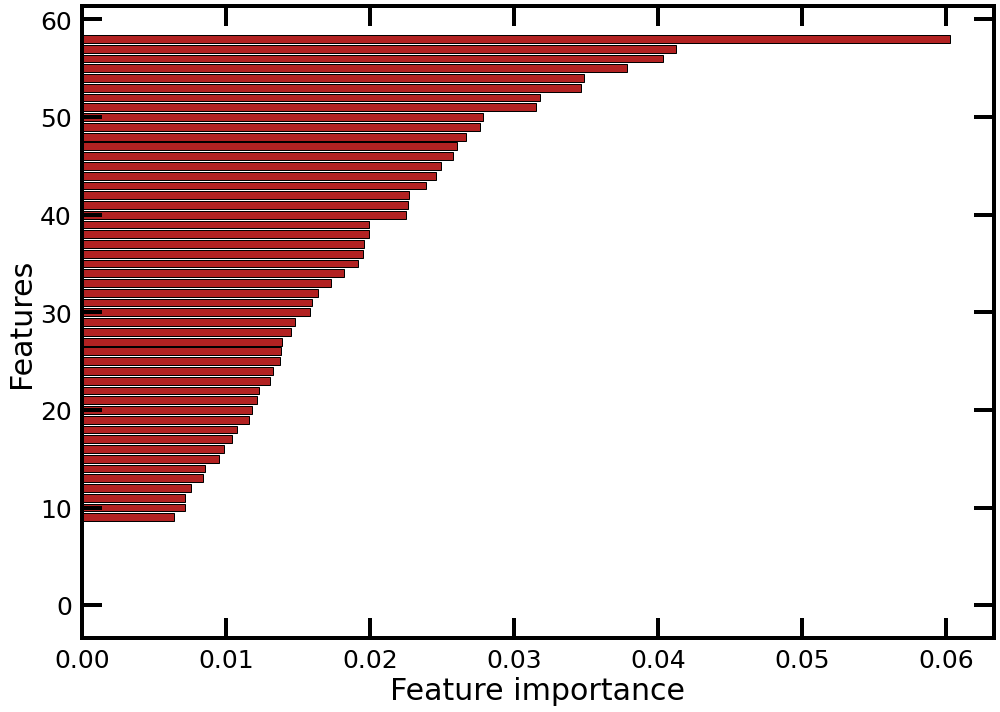

In [240]:
fig, axs = plt.subplots(1,1, figsize=(14,10))


axs.barh(ordered_feat_imp_tree.index, ordered_feat_imp_tree['Importance'], ec='black', color='firebrick')

for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_xlabel('Feature importance', fontsize=30)
axs.xaxis.set_ticks_position('both')
axs.set_ylabel('Features', fontsize=30)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)

axs.tick_params(labelsize=25)

plt.tight_layout()
fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/stress_xgb_tree_feat_imp_no_txt_no_call.svg', bbox_inches='tight')

In [31]:
xgb_model = XGBClassifier(booster = 'gblinear', use_label_encoder=False)
xgb_linear_parameters = {'updater': ['shotgun', 'coord_descent'],
                        'feature_selector': ['cyclic', 'shuffle'],
                        'lambda':[1, 0.1, 0.01], 'alpha':[1, 0.1, 0.01]}

In [32]:
%%time
xgb_linear = GridSearchCV(xgb_model, xgb_linear_parameters, refit=True, n_jobs = -1, verbose=2)
xgb_linear.fit(X_train, y_train, eval_metric= 'logloss')
xgb_linear_best = xgb_linear.best_estimator_
print('*'*20, 'Validation', '*'*20)
print(classification_report(y_val, xgb_linear_best.predict(X_val)))
print('\n')
print('Best estimator:', xgb_linear.best_estimator_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
******************** Validation ********************
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       100
           1       0.00      0.00      0.00        20

    accuracy                           0.83       120
   macro avg       0.42      0.50      0.45       120
weighted avg       0.69      0.83      0.76       120



Best estimator: XGBClassifier(alpha=1, base_score=0.5, booster='gblinear',
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, feature_selector='cyclic', gamma=None,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              lambda=1, learning_rate=0.5, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=4, num_parallel_tree=None,
              random_state=0, reg_alpha=0,

The concept of feature importance is specific to decision trees, as the definition specifically refers to "splits"

In [33]:
xgb_model = XGBClassifier(booster = 'dart',use_label_encoder=False)
xgb_dart_parameters = {'sample_type': ['uniform'],
                      'normalize_type': ['tree'], 'rate_drop': [0.0, 0.1],
                       'skip_drop': [0.0, 0.1, 0.5], 
                      'eta': [0.1, 0.01], 'max_depth': [6, 8], 'lambda':[1, 0.1, 0.01], 
                       'alpha':[1, 0.1, 0.01]}

In [34]:
%%time
xgb_dart = GridSearchCV(xgb_model, xgb_dart_parameters, refit=True, n_jobs = -1, verbose=2)
xgb_dart.fit(X_train, y_train, eval_metric='logloss')
xgb_dart_best = xgb_dart.best_estimator_
print('*'*20, 'Validation', '*'*20)
print(classification_report(y_val, xgb_dart_best.predict(X_val)))
print('\n')
print('Best estimator:', xgb_dart.best_estimator_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
******************** Validation ********************
              precision    recall  f1-score   support

           0       0.83      0.99      0.90       100
           1       0.00      0.00      0.00        20

    accuracy                           0.82       120
   macro avg       0.42      0.49      0.45       120
weighted avg       0.69      0.82      0.75       120



Best estimator: XGBClassifier(alpha=1, base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              lambda=1, learning_rate=0.100000001, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              normalize_type='tree', num_parallel_tree=1, random_state=0,
              rate_drop=0.1, reg_alpha=1,

In [251]:
feat_importances_xgb_dart = pd.DataFrame(zip(important_features, 
                                             xgb_dart_best.feature_importances_), 
                                         columns = ['Features', 'Importance'])

In [36]:
#feat_importances_xgb_dart

In [37]:
feat_importances_xgb_dart.max()

Features      number of distinct locations
Importance                       0.0427172
dtype: object

In [38]:
ordered_feat_imp_dart = feat_importances_xgb_dart.sort_values(by= ['Importance'])

In [39]:
ordered_feat_imp_dart = ordered_feat_imp_dart.reset_index()

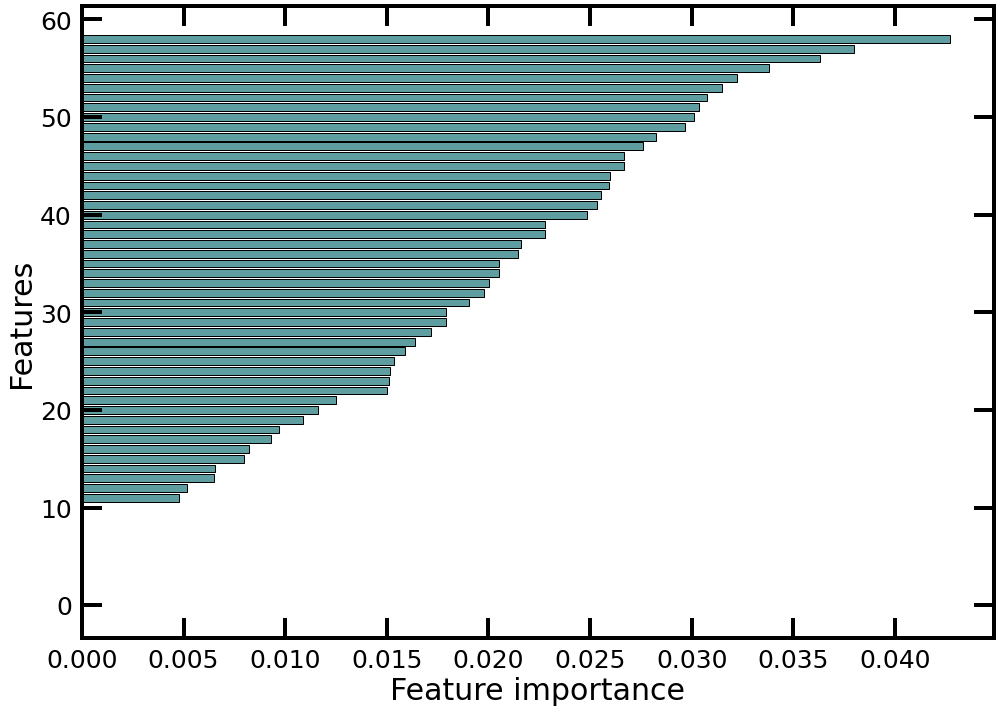

In [40]:
fig, axs = plt.subplots(1,1, figsize=(14,10))


axs.barh(ordered_feat_imp_dart.index, ordered_feat_imp_dart['Importance'], ec='black', 
         color='cadetblue')

for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_xlabel('Feature importance', fontsize=30)
axs.xaxis.set_ticks_position('both')
axs.set_ylabel('Features', fontsize=30)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)

axs.tick_params(labelsize=25)

plt.tight_layout()
#fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/xgb_dart_feat_imp_no_txt_no_call.svg', bbox_inches='tight')

# TabNet:

In [270]:
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

In [271]:
clf1 = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                        n_d=8, n_a=8, n_steps=3, 
                        gamma=1.3, n_independent=3, n_shared=4, epsilon=1e-15, 
                        momentum=0.01, lambda_sparse=0.001, seed=0, clip_value=2, verbose=1, 
                       optimizer_params={'lr': 1e-2, 'weight_decay': 1e-3},
                        scheduler_params={'step_size':50,
                                         "gamma":0.90},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

Device used : cpu


In [272]:
clf1.fit(
    X_train,y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=1000 , patience=70,
    loss_fn = torch.nn.CrossEntropyLoss(),
    batch_size=256, virtual_batch_size=256,
    num_workers=0,
    weights=1,
    drop_last=False
)

epoch 0  | loss: 0.91467 | train_accuracy: 0.48375 | valid_accuracy: 0.53333 |  0:00:00s
epoch 1  | loss: 0.84172 | train_accuracy: 0.42599 | valid_accuracy: 0.425   |  0:00:00s
epoch 2  | loss: 0.89413 | train_accuracy: 0.33935 | valid_accuracy: 0.33333 |  0:00:00s
epoch 3  | loss: 0.74979 | train_accuracy: 0.27076 | valid_accuracy: 0.21667 |  0:00:00s
epoch 4  | loss: 0.73556 | train_accuracy: 0.26354 | valid_accuracy: 0.2     |  0:00:01s
epoch 5  | loss: 0.72387 | train_accuracy: 0.213   | valid_accuracy: 0.21667 |  0:00:01s
epoch 6  | loss: 0.68847 | train_accuracy: 0.19134 | valid_accuracy: 0.20833 |  0:00:01s
epoch 7  | loss: 0.78132 | train_accuracy: 0.19495 | valid_accuracy: 0.2     |  0:00:01s
epoch 8  | loss: 0.7365  | train_accuracy: 0.23466 | valid_accuracy: 0.19167 |  0:00:02s
epoch 9  | loss: 0.70736 | train_accuracy: 0.28881 | valid_accuracy: 0.28333 |  0:00:02s
epoch 10 | loss: 0.67375 | train_accuracy: 0.45848 | valid_accuracy: 0.33333 |  0:00:03s
epoch 11 | loss: 0.74

epoch 93 | loss: 0.28929 | train_accuracy: 0.8917  | valid_accuracy: 0.75833 |  0:00:29s
epoch 94 | loss: 0.19157 | train_accuracy: 0.89531 | valid_accuracy: 0.775   |  0:00:29s
epoch 95 | loss: 0.22904 | train_accuracy: 0.89892 | valid_accuracy: 0.76667 |  0:00:29s
epoch 96 | loss: 0.19766 | train_accuracy: 0.90253 | valid_accuracy: 0.76667 |  0:00:29s
epoch 97 | loss: 0.22866 | train_accuracy: 0.89531 | valid_accuracy: 0.75833 |  0:00:30s
epoch 98 | loss: 0.2451  | train_accuracy: 0.89531 | valid_accuracy: 0.75833 |  0:00:30s
epoch 99 | loss: 0.29351 | train_accuracy: 0.89531 | valid_accuracy: 0.75833 |  0:00:31s
epoch 100| loss: 0.29289 | train_accuracy: 0.90975 | valid_accuracy: 0.75833 |  0:00:31s
epoch 101| loss: 0.2579  | train_accuracy: 0.90975 | valid_accuracy: 0.76667 |  0:00:31s
epoch 102| loss: 0.22308 | train_accuracy: 0.91697 | valid_accuracy: 0.76667 |  0:00:31s
epoch 103| loss: 0.20758 | train_accuracy: 0.90253 | valid_accuracy: 0.76667 |  0:00:32s
epoch 104| loss: 0.23

In [275]:
feat_importances_tabnet = pd.DataFrame(zip(important_features, 
                                             clf1.feature_importances_), 
                                         columns = ['Features', 'Importance'])

In [276]:
feat_importances_tabnet

,Features,Importance
0,Mean_Activity_inference,0.005280
1,Std_Activity_inference,0.042812
2,Skew_Activity_inference,0.013174
3,Var_Activity_inference,0.008299
4,Sum_Activity_inference,0.015362
5,Std_audio_inference,0.003939
6,Skew_audio_inference,0.002422
7,Var_audio_inference,0.006827
8,Sum_audio_inference,0.002314
9,Mean_conv_duration,0.004489


In [221]:
preds_valid = clf1.predict(X_val)
valid_acc = accuracy_score(preds_valid, y_val)

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_acc}")

BEST ACCURACY SCORE ON VALIDATION SET : 0.8333333333333334


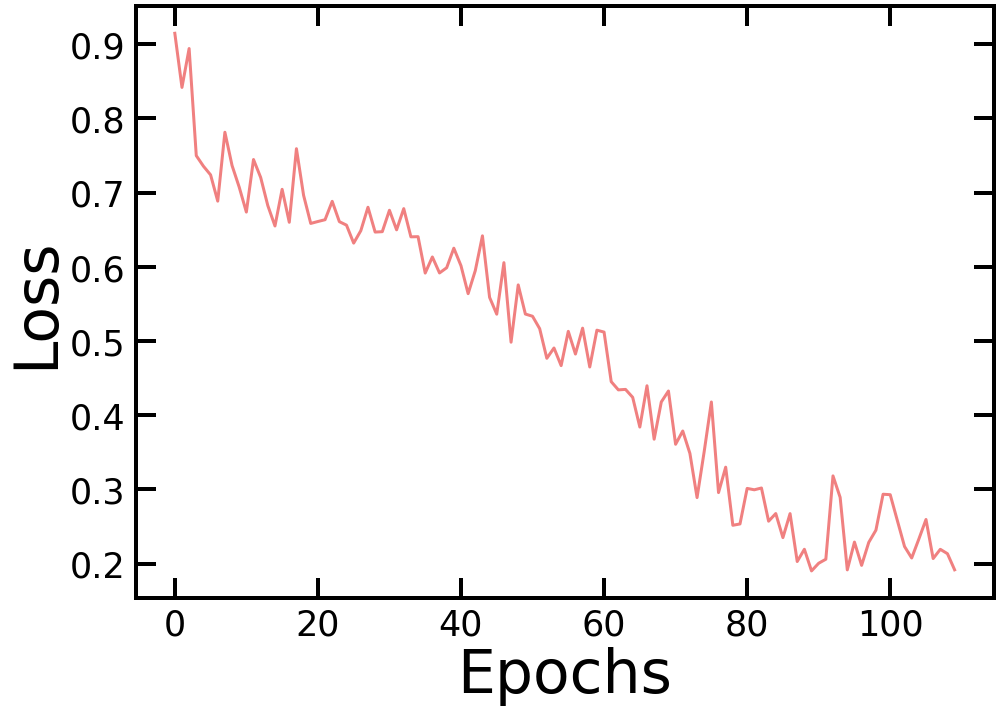

In [225]:
fig, axs = plt.subplots(1,1, figsize=(14,10))

axs.plot(clf1.history['loss'], linewidth=3, color='lightcoral')

for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_ylabel('Loss', fontsize=60)
axs.xaxis.set_ticks_position('both')
axs.set_xlabel('Epochs', fontsize=60)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)


axs.tick_params(labelsize=35)

plt.tight_layout()
fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/stress_tab_net_loss_no_txt_no_call.svg', bbox_inches='tight')

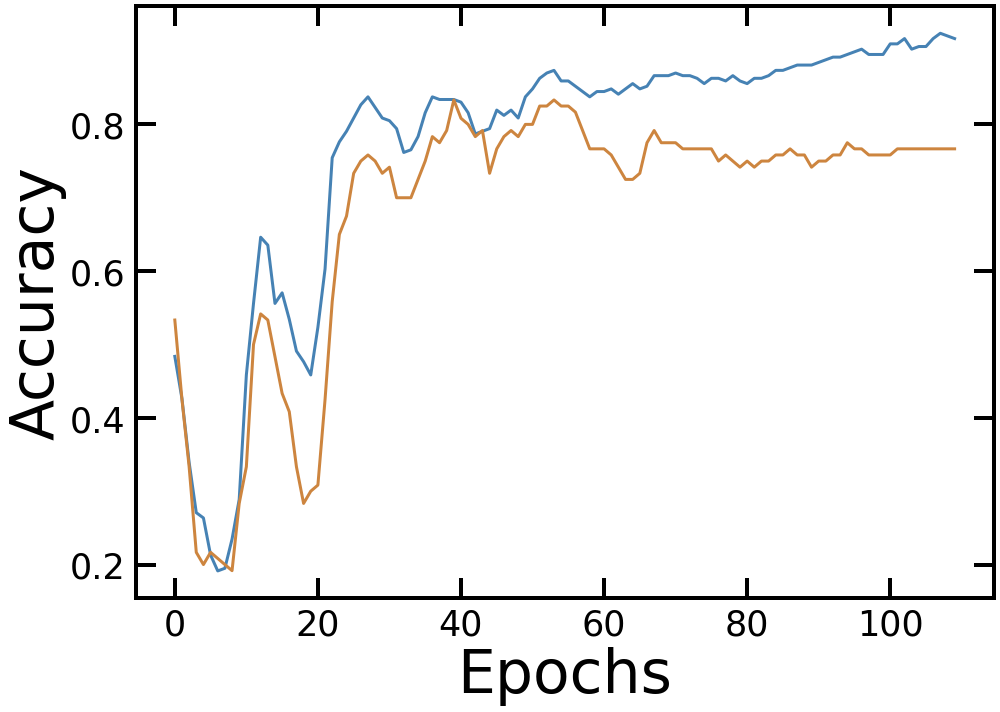

In [226]:
fig, axs = plt.subplots(1,1, figsize=(14,10))

axs.plot(clf1.history['train_accuracy'], linewidth=3, label = 'Training AUC', color='steelblue')
axs.plot(clf1.history['valid_accuracy'], linewidth=3, label = 'Validation AUC', color='peru')
for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_ylabel('Accuracy', fontsize=60)
axs.xaxis.set_ticks_position('both')
axs.set_xlabel('Epochs', fontsize=60)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)
#legend = axs.legend(borderpad=1, labelspacing=2, fontsize=15)
#legend.get_frame().set_linewidth(2.5)
#legend.get_frame().set_edgecolor('black')

axs.tick_params(labelsize=35)

plt.tight_layout()
fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/stress_tabnet_auc_no_txt_no_call.svg', bbox_inches='tight')

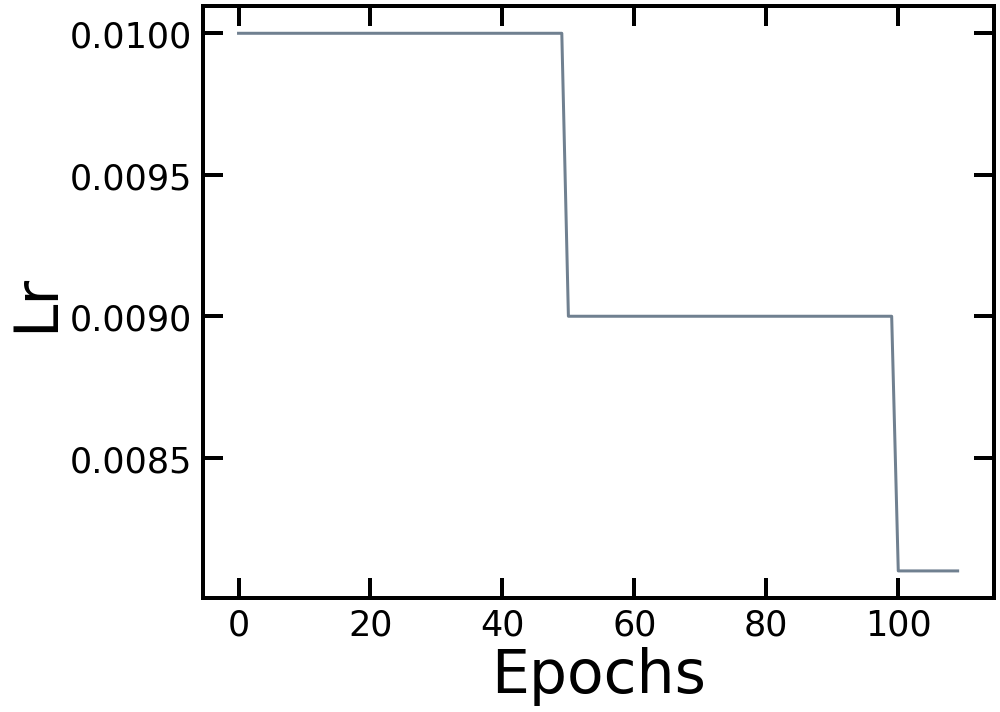

In [227]:
fig, axs = plt.subplots(1,1, figsize=(14,10))

axs.plot(clf1.history['lr'], linewidth=3, color = 'slategray')

for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_ylabel('Lr', fontsize=60)
axs.xaxis.set_ticks_position('both')
axs.set_xlabel('Epochs', fontsize=60)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)


axs.tick_params(labelsize=35)

plt.tight_layout()
fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/stress_tabnet_lr_no_txt_no_call.svg', bbox_inches='tight')

In [258]:
feat_importances_tabnet.max()

Features      number of distinct locations
Importance                        0.221501
dtype: object

In [259]:
ordered_feat_imp_tabnet = feat_importances_tabnet.sort_values(by = ['Importance'])
ordered_feat_imp_tabnet = ordered_feat_imp_tabnet.reset_index()

In [260]:
ordered_feat_imp_tabnet

,index,Features,Importance
0,56,Mean_hour_sleep,0.000458
1,12,Min_conv_duration,0.001289
2,16,Mean_dark_duration,0.001511
3,11,Median_conv_duration,0.001693
4,50,Var_phone_lock_duration,0.002015
5,8,Sum_audio_inference,0.002314
6,33,Max_longitude,0.002325
7,6,Skew_audio_inference,0.002422
8,22,Var_dark_duration,0.002708
9,48,Max_phone_lock_duration,0.002890


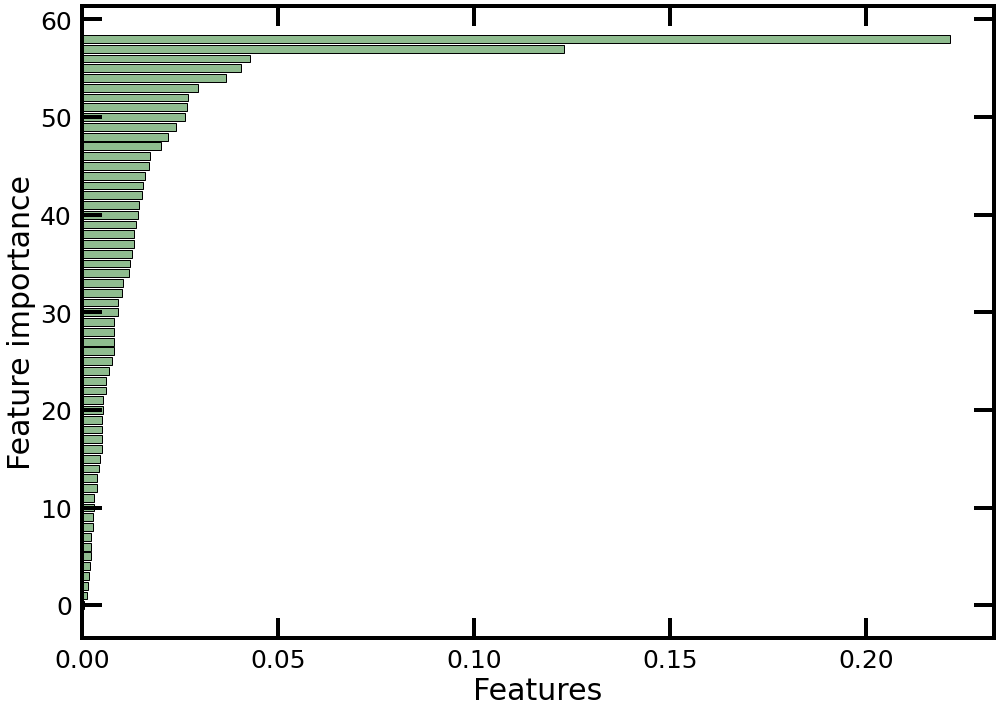

In [233]:
fig, axs = plt.subplots(1,1, figsize=(14,10))


axs.barh(ordered_feat_imp_tabnet.index, ordered_feat_imp_tabnet['Importance'], 
        ec='black', color='darkseagreen')

for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_ylabel('Feature importance', fontsize=30)
axs.xaxis.set_ticks_position('both')
axs.set_xlabel('Features', fontsize=30)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)


axs.tick_params(labelsize=25)

plt.tight_layout()
fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/stress_tabnet_feat_imp_no_txt_no_call.svg', bbox_inches='tight')

In [234]:
explain_matrix, masks = clf1.explain(X_val)

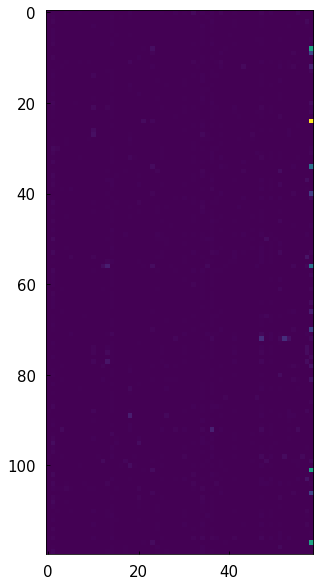

In [267]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))
axs.tick_params(which='both', direction="in", pad=10)
axs.tick_params(labelsize=15)
axs.imshow(explain_matrix)

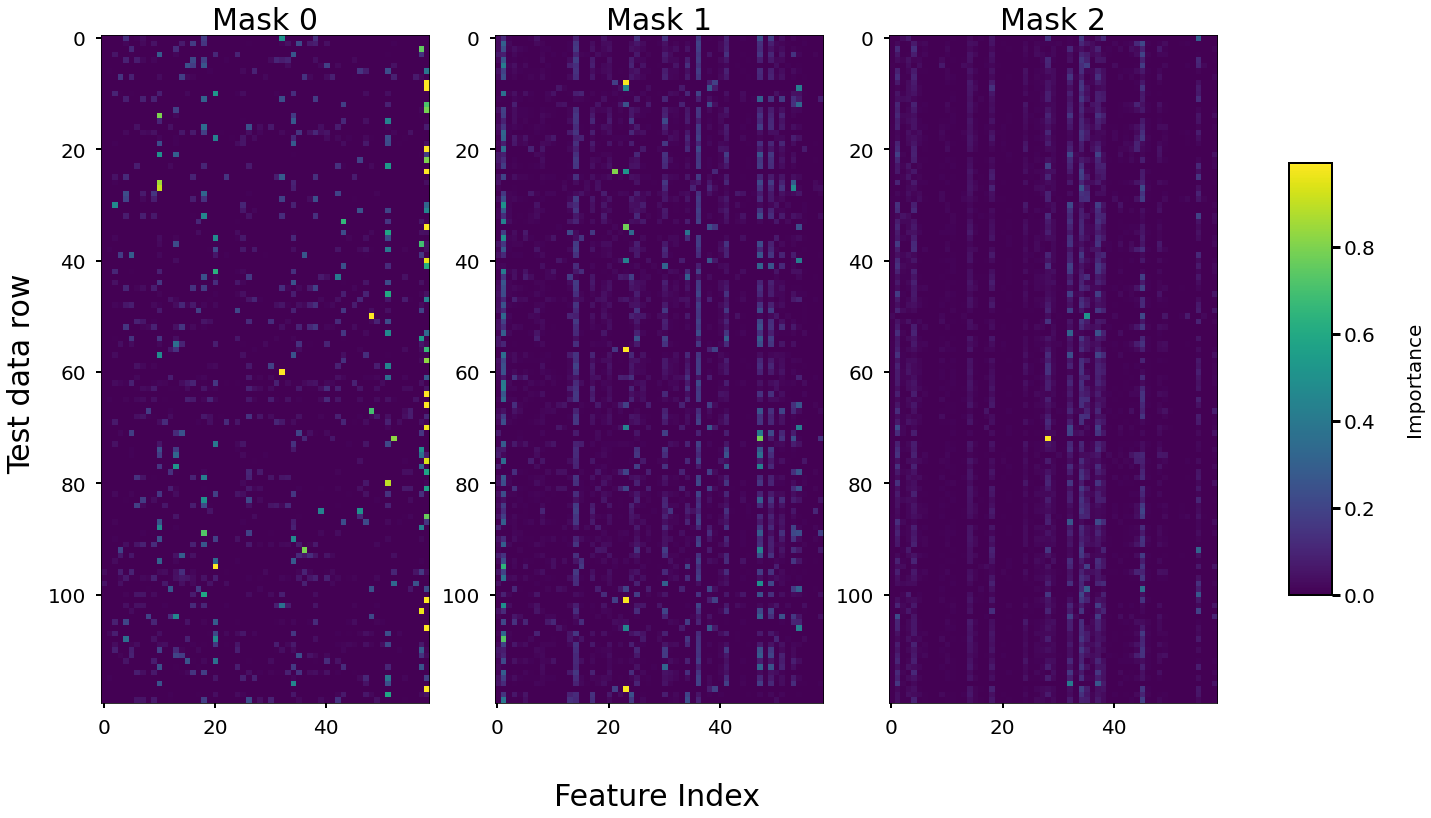

In [249]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    
    #axs[i].set_ylabel('Test Data Row', fontsize=30)
    #axs[i].set_xlabel('Feature index', fontsize=30)

    axs[i].tick_params(which='both', direction="out", pad=10, length=5, width=2)
    axs[i].tick_params(labelsize=20)
    im = axs[i].imshow(masks[i])
    axs[i].set_title(f"Mask {i}", fontsize=30)
    
fig.text(0.44, 0.2, 'Feature Index', fontsize=30)
fig.text(0.06, 0.5, 'Test data row', va='center', rotation='vertical', fontsize=30)

cax = fig.add_axes([0.95, 0.346, 0.03, 0.3])
cb = fig.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=20, length=8, width=3)
cb.outline.set_linewidth(2)
cb.set_label('Importance', fontsize = 20, rotation = 'vertical', labelpad=30)
fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/stress_tabnet_masks_no_txt_no_call.svg', bbox_inches='tight')

In [135]:
clf2 = TabNetClassifier(
clf2_params = {'optimizer_fn':[torch.optim.Adam, torch.optim.Adamax],
             'optimizer_params':[dict(lr=2e-2), dict(lr=1e-2)],
               'n_steps':[3,5], 'momentum':[0.02, 0.05],
             'scheduler_params':[{"step_size":50, "gamma":0.9}],
             'scheduler_fn': [torch.optim.lr_scheduler.StepLR],
             'mask_type':['entmax']}
    
clf_grid = GridSearchCV(clf2, clf2_params, scoring = sklearn.metrics.accuracy_score,
                       refit=True, n_jobs = -1, verbose=1)
clf_grid.fit(
    X_train,y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=1000 , patience=70,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False
)

In [137]:
#print('Best estimator:', clf_grid.best_estimator_)

Best estimator: TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.LambdaLR'>, scheduler_params={'step_size': 50, 'gamma': 0.9}, mask_type='entmax', input_dim=22, output_dim=2, device_name='auto')
